In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np 
import pandas as pd 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from sklearn import preprocessing



In [3]:
class SimpleNet(nn.Module):
    def __init__(self, input_output, layers, activation_func=None):
        super().__init__()
        input_dim = input_output[0]
        output_dim = input_output[1]
        self.beta = nn.ModuleList()
        self.sig = nn.ModuleList() if activation_func is not None else None
        while len(activation_func) < len(layers):
            activation_func.append(activation_func[-1])
            
        for i in range(len(layers)):
            if i == 0:
                self.beta.append(nn.Linear(input_dim, layers[i]))

            if i < len(layers)-1:
                self.beta.append(nn.Linear(layers[i], layers[i+1]))
                if self.sig is not None:
                    self.sig.append(activation_func[i])
                
            else:
                self.beta.append(nn.Linear(layers[i],output_dim))
        
        print(len(self.beta), len(self.sig))
        self.layers = len(self.beta)

    def forward(self, x):
        for i in range(self.layers):
            f = self.beta[i]
            if i == 0 or i == self.layers - 1 or self.sig is None:
                x = f(x)
            else:
                a = self.sig[i-1]
                x = a(f(x))
        return x

In [4]:
df = pd.read_csv('n-hexane-vle.csv')

In [5]:
dataset = df.values
d1 = dataset[0:1000,:]
d1 = d1[d1[:,4]<30]
np.random.shuffle(d1)
v1 = np.log(d1[:,0])
p1_eos = d1[:,3]
p1_real = np.log(d1[:,4])

d2 = dataset[dataset[:,4]<30]

np.random.shuffle(d2)
v2 = np.log(d2[:,0])
T2 = d2[:,2]
p2_eos = d2[:,3]
p2_real = np.log(d2[:,4])

d2v = np.vstack([dataset[0:1000,:],dataset[90000:91000,:],dataset[180000:181000,:]])
d2v = d2v[d2v[:,4] < 30]
v2v = np.log(d2v[:,0])
T2v = d2v[:,2]
p2v = d2v[:,3]


In [62]:
X = np.column_stack([v2, T2])
Y = p2_real.reshape((np.size(p2_eos),1))
XV = np.column_stack([v2v, T2v])
YV = p2v.reshape((np.size(p2v),1))


Xscaler = preprocessing.StandardScaler()
X = Xscaler.fit_transform(X)
XV = Xscaler.transform(XV)

Yscaler = preprocessing.StandardScaler()
Y = Yscaler.fit_transform(Y)
YV = Yscaler.transform(YV)

X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()
XV = torch.from_numpy(XV).float()
YV = torch.from_numpy(YV).float()

model = SimpleNet((2,1), [500,200,20], [nn.Tanh(),nn.ReLU()])
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

4 2


Text(0.5,1,'MSE: 229.18240')

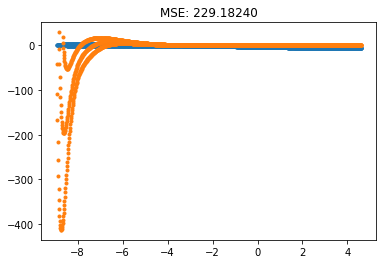

In [73]:
for i in range(10):
    model.train()
    optimizer.zero_grad()

    Y_ = model(X)
    loss = criterion(Y_, Y)

    # print('epoch: ', epoch,' loss: ', loss.item())
    loss.backward()
    optimizer.step()

model.eval()
with torch.no_grad():
    YV_ = model(XV)
    loss = criterion(YV_, YV)

fig, ax = plt.subplots()
ax.plot(Xscaler.inverse_transform(XV.numpy())[:,0], Yscaler.inverse_transform(YV_.numpy()), '.', label='pred')
ax.plot(Xscaler.inverse_transform(XV.numpy())[:,0], Yscaler.inverse_transform(YV.numpy()), '.', label='data')

ax.set_title(f"MSE: {loss.item():0.5f}")

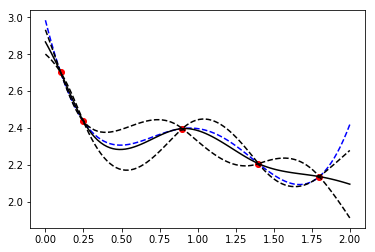

In [278]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
x = np.linspace(0,2,100)
y = -0.6*np.sin(x) + (x-1)**2 + 1.513*x + 0.83*np.cos(x) + 0.383*np.sin(2*x) - 0.45*np.cos(3*x) - 0.141*(x-2)**3 + 0.094*(x-1.5)**4

npt = 5
gp = np.array([0.1,0.25, 0.9, 1.4,1.8])
gpy = -0.6*np.sin(gp)+(gp-1)**2+1.513*gp+0.83*np.cos(gp)+0.383*np.sin(2*gp)-0.45*np.cos(3*gp)-0.141*(gp-2)**3+0.094*(gp-1.5)**4

kern = 1. * kernels.Matern(length_scale=1)
gpr = GaussianProcessRegressor(kernel=kern).fit(gp.reshape((npt,1)), gpy.reshape((npt,1)))
fitted, stdev = gpr.predict(x.reshape((100,1)), return_std=True)

fig,ax = plt.subplots()
ax.plot(x,y,'b--')
ax.plot(gp,gpy,'ro')
ax.plot(x,fitted,'k-')
ax.plot(x,fitted.reshape((100,))+1*stdev,'k--')
ax.plot(x,fitted.reshape((100,))-1*stdev,'k--')

pd.DataFrame(np.column_stack([x,y,fitted,fitted.reshape((100,))+1*stdev,fitted.reshape((100,))-1*stdev])).to_csv('gpr_test.csv',index=None)
pd.DataFrame(np.column_stack([gp,gpy])).to_csv('gpr_train.csv',index=None)

